# Assignment 2

In [1]:
# All libraries required
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

from tensorflow.keras import layers

2024-05-17 14:44:36.407811: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-05-17 14:44:37.089347: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-05-17 14:44:38.282510: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [2]:
# Tensorflow Version
print(tf.__version__)

2.16.1


In [3]:
# Allocate more memory - https://www.tensorflow.org/guide/gpu

gpus = tf.config.list_physical_devices('GPU')
if gpus:
  # Restrict TensorFlow to only allocate 4GB of memory on the first GPU
  try:
    tf.config.set_logical_device_configuration(
        gpus[0],
        [tf.config.LogicalDeviceConfiguration(memory_limit=4096)])
    logical_gpus = tf.config.list_logical_devices('GPU')
    print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
  except RuntimeError as e:
    # Virtual devices must be set before GPUs have been initialized
    print(e)

1 Physical GPUs, 1 Logical GPUs


2024-05-17 14:44:42.160111: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:984] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-05-17 14:44:42.394931: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:984] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-05-17 14:44:42.394971: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:984] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-05-17 14:44:42.398486: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:984] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-05-17 14:44:42.398528: I external/local_xla/xla/stream_executor

In [4]:
# Plotting history graph
def plot_loss(history, which='loss'):
    plt.plot(history.history[which], label='train')
    try:
        plt.plot(history.history['val_'+which], label='validation')
    except:
        None
    plt.xlabel('Epoch')
    plt.ylabel(which)
    plt.legend()
    plt.grid(True)

## Model 1: Grayscale (Simple)

In [5]:
# Get data - https://www.tensorflow.org/tutorials/load_data/images#load_data_using_a_keras_utility

# Parameters
batch_size = 125912
IMG_SIZE = (512, 512)
data_dir = './hagridset'
seed_no = 388741
validation_split = 0.3

# Dataset - https://stackoverflow.com/questions/66036271/splitting-a-tensorflow-dataset-into-training-test-and-validation-sets-from-ker

# Auto split to training set (70%)
training_data_set = tf.keras.utils.image_dataset_from_directory(data_dir,
                                                       image_size = IMG_SIZE,
                                                       validation_split = validation_split,
                                                       subset = 'training',
                                                       seed = seed_no,
                                                       color_mode = 'grayscale',
                                                       shuffle = True)

# Auto split to validation set and test set (30%)
validation_data_set = tf.keras.utils.image_dataset_from_directory(data_dir,
                                                       image_size = IMG_SIZE,
                                                       validation_split = validation_split,
                                                       subset = 'validation',
                                                       seed = seed_no,
                                                       color_mode = 'grayscale',
                                                       shuffle = True)

# Split further to validation set (10%) and test set (20%)
validation_batches = tf.data.experimental.cardinality(validation_data_set)
test_data_set = validation_data_set.take((2 * validation_batches) // 3)
validation_data_set = validation_data_set.skip((2 * validation_batches) // 3)

Found 125912 files belonging to 18 classes.
Using 88139 files for training.
Found 125912 files belonging to 18 classes.
Using 37773 files for validation.


In [6]:
# Number of classes
num_classes = len(training_data_set.class_names)
num_classes

# Model building
model = tf.keras.models.Sequential()
model.add(tf.keras.Input(shape=(IMG_SIZE[0], IMG_SIZE[1], 1)))
model.add(layers.Conv2D(16, 3, strides=2, padding='same', activation='relu'))
model.add(layers.MaxPooling2D())
model.add(layers.Conv2D(32, 3, padding='same', activation='relu'))
model.add(layers.MaxPooling2D())
model.add(layers.Flatten())
model.add(layers.Dense(64, activation='relu'))
model.add(layers.Dense(num_classes, activation='softmax'))

model.compile(
    optimizer=tf.keras.optimizers.Adam(0.001),
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
    metrics=['accuracy'],
)

In [7]:
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 256, 256, 16)   │           160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 128, 128, 16)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 128, 128, 32)   │         4,640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 64, 64, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 131072)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 64)             │     8,388,672 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 18)             │         1,170 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 8,394,642 (32.02 MB)

 Trainable params: 8,394,642 (32.02 MB)

 Non-trainable params: 0 (0.00 B)

In [8]:
callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)
history = model.fit(training_data_set, validation_data=validation_data_set, epochs=50, callbacks=[callback])

Epoch 1/50


I0000 00:00:1715953630.593205    1373 service.cc:145] XLA service 0x7f6e28003d60 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1715953630.593264    1373 service.cc:153]   StreamExecutor device (0): NVIDIA GeForce RTX 3050 Ti Laptop GPU, Compute Capability 8.6
2024-05-17 14:47:10.659321: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:268] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2024-05-17 14:47:10.871505: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:465] Loaded cuDNN version 8907


   5/2755 ━━━━━━━━━━━━━━━━━━━━ 1:43 38ms/step - accuracy: 0.0682 - loss: 1523.1824

I0000 00:00:1715953637.776440    1373 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


2755/2755 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - accuracy: 0.0565 - loss: 36.4150

KeyboardInterrupt: 

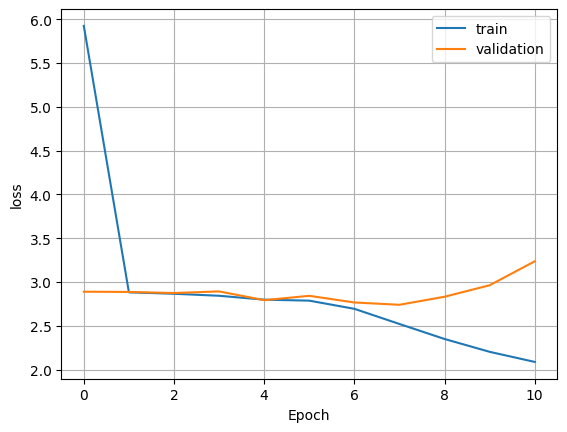

In [ ]:
plot_loss(history)

In [ ]:
result1 = model.evaluate(test_data_set)
result1

787/787 ━━━━━━━━━━━━━━━━━━━━ 17s 21ms/step - accuracy: 0.1594 - loss: 2.6960


[2.7050747871398926, 0.15938691794872284]

## Model 2: Grayscale (Deep)

In [ ]:
# Number of classes
num_classes = len(training_data_set.class_names)
num_classes

# Model building - using the same dataset from the previous model
model2 = tf.keras.models.Sequential()
model2.add(tf.keras.Input(shape=(IMG_SIZE[0], IMG_SIZE[1], 1)))
model2.add(layers.Conv2D(12, 3, strides=2, padding='same', activation='relu'))
model2.add(layers.MaxPooling2D())
model2.add(layers.Conv2D(18, 3, padding='same', activation='relu'))
model2.add(layers.MaxPooling2D())
model2.add(layers.Conv2D(24, 3, padding='same', activation='relu'))
model2.add(layers.MaxPooling2D())
model2.add(layers.Conv2D(32, 3, padding='same', activation='relu'))
model2.add(layers.MaxPooling2D())
model2.add(layers.Conv2D(48, 3, padding='same', activation='relu'))
model2.add(layers.MaxPooling2D())
model2.add(layers.Conv2D(96, 3, padding='same', activation='relu'))
model2.add(layers.MaxPooling2D())
model2.add(layers.Conv2D(128, 3, padding='same', activation='relu'))
model2.add(layers.MaxPooling2D())
model2.add(layers.Conv2D(192, 3, padding='same', activation='relu'))
model2.add(layers.MaxPooling2D())
model2.add(layers.Flatten())
model2.add(layers.Dense(192, activation='relu'))
model2.add(layers.Dense(num_classes, activation='softmax'))

model2.compile(
    optimizer=tf.keras.optimizers.Adam(0.001),
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
    metrics=['accuracy'],
)

In [ ]:
model2.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_2 (Conv2D)               │ (None, 256, 256, 12)   │           120 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 128, 128, 12)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 128, 128, 18)   │         1,962 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 64, 64, 18)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 64, 64, 24)     │         3,912 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_4 (MaxPooling2D)  │ (None, 32, 32, 24)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 32, 32, 32)     │         6,944 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_5 (MaxPooling2D)  │ (None, 16, 16, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_6 (Conv2D)               │ (None, 16, 16, 48)     │        13,872 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_6 (MaxPooling2D)  │ (None, 8, 8, 48)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_7 (Conv2D)               │ (None, 8, 8, 96)       │        41,568 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_7 (MaxPooling2D)  │ (None, 4, 4, 96)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_8 (Conv2D)               │ (None, 4, 4, 128)      │       110,720 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_8 (MaxPooling2D)  │ (None, 2, 2, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_9 (Conv2D)               │ (None, 2, 2, 192)      │       221,376 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_9 (MaxPooling2D)  │ (None, 1, 1, 192)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 192)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 192)            │        37,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 18)             │         3,474 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 441,004 (1.68 MB)

 Trainable params: 441,004 (1.68 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)
history2 = model2.fit(training_data_set, validation_data=validation_data_set, epochs=50, callbacks=[callback])

Epoch 1/50
2755/2755 ━━━━━━━━━━━━━━━━━━━━ 123s 39ms/step - accuracy: 0.1815 - loss: 2.5128 - val_accuracy: 0.5799 - val_loss: 1.3013
Epoch 2/50
2755/2755 ━━━━━━━━━━━━━━━━━━━━ 107s 39ms/step - accuracy: 0.6182 - loss: 1.1689 - val_accuracy: 0.7056 - val_loss: 0.9167
Epoch 3/50
2755/2755 ━━━━━━━━━━━━━━━━━━━━ 96s 35ms/step - accuracy: 0.7273 - loss: 0.8388 - val_accuracy: 0.7483 - val_loss: 0.7817
Epoch 4/50
2755/2755 ━━━━━━━━━━━━━━━━━━━━ 103s 37ms/step - accuracy: 0.7807 - loss: 0.6788 - val_accuracy: 0.7684 - val_loss: 0.7414
Epoch 5/50
2755/2755 ━━━━━━━━━━━━━━━━━━━━ 110s 40ms/step - accuracy: 0.8092 - loss: 0.5854 - val_accuracy: 0.7897 - val_loss: 0.6732
Epoch 6/50
2755/2755 ━━━━━━━━━━━━━━━━━━━━ 104s 38ms/step - accuracy: 0.8253 - loss: 0.5359 - val_accuracy: 0.7496 - val_loss: 0.8931
Epoch 7/50
2755/2755 ━━━━━━━━━━━━━━━━━━━━ 100s 36ms/step - accuracy: 0.8377 - loss: 0.5040 - val_accuracy: 0.8028 - val_loss: 0.6699
Epoch 8/50
2755/2755 ━━━━━━━━━━━━━━━━━━━━ 98s 36ms/step - accuracy: 0.

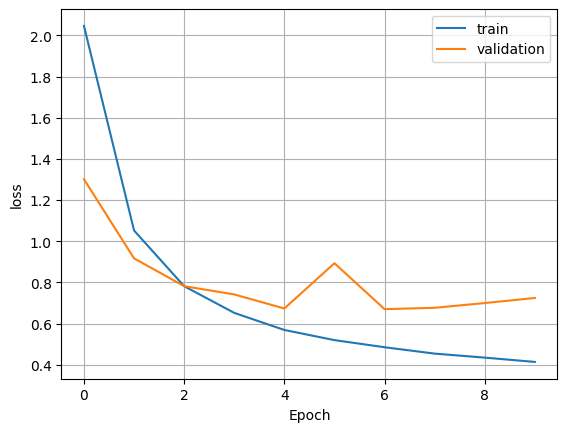

In [ ]:
plot_loss(history2)

In [ ]:
result2 = model2.evaluate(test_data_set)
result2

787/787 ━━━━━━━━━━━━━━━━━━━━ 16s 20ms/step - accuracy: 0.8058 - loss: 0.6499


[0.6636701822280884, 0.802811324596405]

## Model 3: Colour (Deep)

In [ ]:
# Get data - https://www.tensorflow.org/tutorials/load_data/images#load_data_using_a_keras_utility

# Parameters
batch_size = 125912
IMG_SIZE = (512, 512)
data_dir = './hagridset'
seed_no = 388741
validation_split = 0.3

# Dataset - https://stackoverflow.com/questions/66036271/splitting-a-tensorflow-dataset-into-training-test-and-validation-sets-from-ker

# Auto split to training set (70%)
training_data_set = tf.keras.utils.image_dataset_from_directory(data_dir,
                                                       image_size = IMG_SIZE,
                                                       validation_split = validation_split,
                                                       subset = 'training',
                                                       seed = seed_no,
                                                       color_mode = "rgb",
                                                       label_mode='categorical',
                                                       shuffle = True)

# Auto split to validation set and test set (30%)
validation_data_set = tf.keras.utils.image_dataset_from_directory(data_dir,
                                                       image_size = IMG_SIZE,
                                                       validation_split = validation_split,
                                                       subset = 'validation',
                                                       seed = seed_no,
                                                       color_mode = "rgb",
                                                       label_mode='categorical',
                                                       shuffle = True)

# Split further to validation set (10%) and test set (20%)
validation_batches = tf.data.experimental.cardinality(validation_data_set)
test_data_set = validation_data_set.take((2 * validation_batches) // 3)
validation_data_set = validation_data_set.skip((2 * validation_batches) // 3)

Found 125912 files belonging to 18 classes.
Using 88139 files for training.
Found 125912 files belonging to 18 classes.
Using 37773 files for validation.


In [ ]:
# Number of classes
num_classes = len(training_data_set.class_names)
num_classes

# Model building
model3 = tf.keras.models.Sequential()
model3.add(tf.keras.Input(shape=(IMG_SIZE[0], IMG_SIZE[1], 3)))
model3.add(layers.Conv2D(12, 3, strides=2, padding='same', activation='relu'))
model3.add(layers.MaxPooling2D())
model3.add(layers.Conv2D(18, 3, padding='same', activation='relu'))
model3.add(layers.MaxPooling2D())
model3.add(layers.Conv2D(24, 3, padding='same', activation='relu'))
model3.add(layers.MaxPooling2D())
model3.add(layers.Conv2D(32, 3, padding='same', activation='relu'))
model3.add(layers.MaxPooling2D())
model3.add(layers.Conv2D(48, 3, padding='same', activation='relu'))
model3.add(layers.MaxPooling2D())
model3.add(layers.Conv2D(96, 3, padding='same', activation='relu'))
model3.add(layers.MaxPooling2D())
model3.add(layers.Conv2D(128, 3, padding='same', activation='relu'))
model3.add(layers.MaxPooling2D())
model3.add(layers.Conv2D(192, 3, padding='same', activation='relu'))
model3.add(layers.MaxPooling2D())
model3.add(layers.Flatten())
model3.add(layers.Dense(192, activation='relu'))
model3.add(layers.Dense(num_classes, activation='softmax'))

In [ ]:
model3.summary()

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_10 (Conv2D)              │ (None, 256, 256, 12)   │           336 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_10 (MaxPooling2D) │ (None, 128, 128, 12)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_11 (Conv2D)              │ (None, 128, 128, 18)   │         1,962 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_11 (MaxPooling2D) │ (None, 64, 64, 18)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_12 (Conv2D)              │ (None, 64, 64, 24)     │         3,912 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_12 (MaxPooling2D) │ (None, 32, 32, 24)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_13 (Conv2D)              │ (None, 32, 32, 32)     │         6,944 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_13 (MaxPooling2D) │ (None, 16, 16, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_14 (Conv2D)              │ (None, 16, 16, 48)     │        13,872 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_14 (MaxPooling2D) │ (None, 8, 8, 48)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_15 (Conv2D)              │ (None, 8, 8, 96)       │        41,568 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_15 (MaxPooling2D) │ (None, 4, 4, 96)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_16 (Conv2D)              │ (None, 4, 4, 128)      │       110,720 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_16 (MaxPooling2D) │ (None, 2, 2, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_17 (Conv2D)              │ (None, 2, 2, 192)      │       221,376 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_17 (MaxPooling2D) │ (None, 1, 1, 192)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_2 (Flatten)             │ (None, 192)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 192)            │        37,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 18)             │         3,474 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 441,220 (1.68 MB)

 Trainable params: 441,220 (1.68 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
model3.compile(optimizer=tf.keras.optimizers.Adam(),
              loss=tf.keras.losses.CategoricalCrossentropy(from_logits=False),
              metrics=['accuracy'])

In [ ]:
callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)
history3 = model3.fit(training_data_set, validation_data=validation_data_set, epochs=50, callbacks=[callback])

Epoch 1/50
2755/2755 ━━━━━━━━━━━━━━━━━━━━ 154s 54ms/step - accuracy: 0.1894 - loss: 2.5266 - val_accuracy: 0.6873 - val_loss: 0.9886
Epoch 2/50
2755/2755 ━━━━━━━━━━━━━━━━━━━━ 148s 54ms/step - accuracy: 0.7059 - loss: 0.9253 - val_accuracy: 0.7669 - val_loss: 0.7500
Epoch 3/50
2755/2755 ━━━━━━━━━━━━━━━━━━━━ 143s 52ms/step - accuracy: 0.7872 - loss: 0.6750 - val_accuracy: 0.8059 - val_loss: 0.6510
Epoch 4/50
2755/2755 ━━━━━━━━━━━━━━━━━━━━ 141s 51ms/step - accuracy: 0.8224 - loss: 0.5604 - val_accuracy: 0.8141 - val_loss: 0.6362
Epoch 5/50
2755/2755 ━━━━━━━━━━━━━━━━━━━━ 139s 50ms/step - accuracy: 0.8370 - loss: 0.5159 - val_accuracy: 0.7908 - val_loss: 0.6684
Epoch 6/50
2755/2755 ━━━━━━━━━━━━━━━━━━━━ 143s 52ms/step - accuracy: 0.8489 - loss: 0.4775 - val_accuracy: 0.8382 - val_loss: 0.5301
Epoch 7/50
2755/2755 ━━━━━━━━━━━━━━━━━━━━ 158s 57ms/step - accuracy: 0.8568 - loss: 0.4551 - val_accuracy: 0.8231 - val_loss: 0.6158
Epoch 8/50
2755/2755 ━━━━━━━━━━━━━━━━━━━━ 176s 64ms/step - accuracy: 

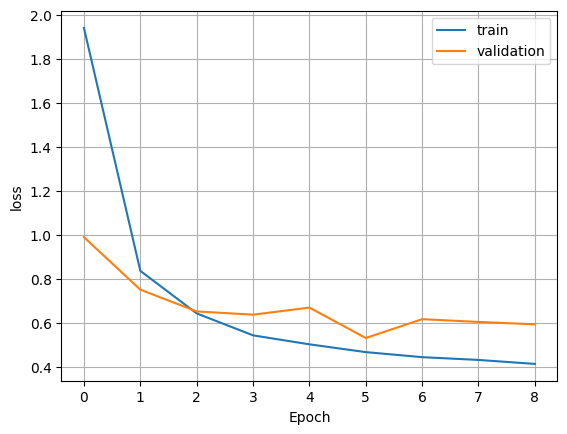

In [ ]:
plot_loss(history3)

In [ ]:
result3 = model3.evaluate(test_data_set)
result3

787/787 ━━━━━━━━━━━━━━━━━━━━ 24s 30ms/step - accuracy: 0.8413 - loss: 0.5194


[0.5263027548789978, 0.8395807147026062]

## Model 4: RGB (Deep with Dropout)

In [ ]:
# Number of classes
num_classes = len(training_data_set.class_names)
num_classes

# Model building - using same dataset as previous
model4 = tf.keras.models.Sequential()
model4.add(tf.keras.Input(shape=(IMG_SIZE[0], IMG_SIZE[1], 3)))
model4.add(layers.Conv2D(12, 3, strides=2, padding='same', activation='relu'))
model4.add(layers.MaxPooling2D())
model4.add(layers.Dropout(0.2))
model4.add(layers.Conv2D(18, 3, padding='same', activation='relu'))
model4.add(layers.MaxPooling2D())
model4.add(layers.Dropout(0.2))
model4.add(layers.Conv2D(24, 3, padding='same', activation='relu'))
model4.add(layers.MaxPooling2D())
model4.add(layers.Dropout(0.2))
model4.add(layers.Conv2D(32, 3, padding='same', activation='relu'))
model4.add(layers.MaxPooling2D())
model4.add(layers.Dropout(0.2))
model4.add(layers.Conv2D(48, 3, padding='same', activation='relu'))
model4.add(layers.MaxPooling2D())
model4.add(layers.Dropout(0.2))
model4.add(layers.Conv2D(96, 3, padding='same', activation='relu'))
model4.add(layers.MaxPooling2D())
model4.add(layers.Dropout(0.2))
model4.add(layers.Conv2D(128, 3, padding='same', activation='relu'))
model4.add(layers.MaxPooling2D())
model4.add(layers.Dropout(0.2))
model4.add(layers.Conv2D(192, 3, padding='same', activation='relu'))
model4.add(layers.MaxPooling2D())
model4.add(layers.Flatten())
model4.add(layers.Dense(192, activation='relu'))
model4.add(layers.Dense(num_classes, activation='softmax'))

model4.compile(optimizer=tf.keras.optimizers.Adam(),
              loss=tf.keras.losses.CategoricalCrossentropy(from_logits=False),
              metrics=['accuracy'])

In [ ]:
model4.summary()

Model: "sequential_14"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_94 (Conv2D)              │ (None, 256, 256, 12)   │           336 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_94 (MaxPooling2D) │ (None, 128, 128, 12)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_23 (Dropout)            │ (None, 128, 128, 12)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_95 (Conv2D)              │ (None, 128, 128, 18)   │         1,962 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_95 (MaxPooling2D) │ (None, 64, 64, 18)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_24 (Dropout)            │ (None, 64, 64, 18)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_96 (Conv2D)              │ (None, 64, 64, 24)     │         3,912 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_96 (MaxPooling2D) │ (None, 32, 32, 24)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_25 (Dropout)            │ (None, 32, 32, 24)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_97 (Conv2D)              │ (None, 32, 32, 32)     │         6,944 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_97 (MaxPooling2D) │ (None, 16, 16, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_26 (Dropout)            │ (None, 16, 16, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_98 (Conv2D)              │ (None, 16, 16, 48)     │        13,872 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_98 (MaxPooling2D) │ (None, 8, 8, 48)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_27 (Dropout)            │ (None, 8, 8, 48)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_99 (Conv2D)              │ (None, 8, 8, 96)       │        41,568 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_99 (MaxPooling2D) │ (None, 4, 4, 96)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_28 (Dropout)            │ (None, 4, 4, 96)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_100 (Conv2D)             │ (None, 4, 4, 128)      │       110,720 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_100               │ (None, 2, 2, 128)      │             0 │
│ (MaxPooling2D)                  │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_29 (Dropout)            │ (None, 2, 2, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_101 (Conv2D)             │ (None, 2, 2, 192)      │       221,376 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_101               │ (None, 1, 1, 192)      │             0 │
│ (MaxPooling2D)                  │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_13 (Flatten)            │ (None, 192)            │             

 Total params: 441,220 (1.68 MB)

 Trainable params: 441,220 (1.68 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)
history4 = model4.fit(training_data_set, validation_data=validation_data_set, epochs=50, callbacks=[callback])

Epoch 1/50
2755/2755 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step - accuracy: 0.0589 - loss: 3.1675

2024-05-17 00:36:27.737014: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 134220032 bytes after encountering the first element of size 134220032 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size


2755/2755 ━━━━━━━━━━━━━━━━━━━━ 216s 74ms/step - accuracy: 0.0589 - loss: 3.1675 - val_accuracy: 0.0576 - val_loss: 2.8918
Epoch 2/50
2755/2755 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step - accuracy: 0.1477 - loss: 2.6478

2024-05-17 00:39:45.008789: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 134220032 bytes after encountering the first element of size 134220032 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size


2755/2755 ━━━━━━━━━━━━━━━━━━━━ 195s 71ms/step - accuracy: 0.1477 - loss: 2.6477 - val_accuracy: 0.4835 - val_loss: 1.6845
Epoch 3/50
2754/2755 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step - accuracy: 0.4824 - loss: 1.6183

2024-05-17 00:42:37.362498: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 100665600 bytes after encountering the first element of size 100665600 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size


2755/2755 ━━━━━━━━━━━━━━━━━━━━ 172s 63ms/step - accuracy: 0.4825 - loss: 1.6182 - val_accuracy: 0.6363 - val_loss: 1.1507
Epoch 4/50
2755/2755 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step - accuracy: 0.5891 - loss: 1.3075

2024-05-17 00:45:46.996972: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 134220032 bytes after encountering the first element of size 134220032 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size


2755/2755 ━━━━━━━━━━━━━━━━━━━━ 192s 70ms/step - accuracy: 0.5891 - loss: 1.3075 - val_accuracy: 0.6714 - val_loss: 1.0689
Epoch 5/50
2755/2755 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step - accuracy: 0.6298 - loss: 1.1752

2024-05-17 00:49:03.550886: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 134220032 bytes after encountering the first element of size 134220032 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size


2755/2755 ━━━━━━━━━━━━━━━━━━━━ 197s 71ms/step - accuracy: 0.6298 - loss: 1.1752 - val_accuracy: 0.6998 - val_loss: 0.9738
Epoch 6/50
2755/2755 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step - accuracy: 0.6595 - loss: 1.0952

2024-05-17 00:52:13.722352: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 134220032 bytes after encountering the first element of size 134220032 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size


2755/2755 ━━━━━━━━━━━━━━━━━━━━ 191s 69ms/step - accuracy: 0.6595 - loss: 1.0952 - val_accuracy: 0.6729 - val_loss: 1.0640
Epoch 7/50
2755/2755 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step - accuracy: 0.6666 - loss: 1.0671

2024-05-17 00:55:28.139017: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 134220032 bytes after encountering the first element of size 134220032 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size


2755/2755 ━━━━━━━━━━━━━━━━━━━━ 192s 70ms/step - accuracy: 0.6666 - loss: 1.0671 - val_accuracy: 0.7232 - val_loss: 0.9125
Epoch 8/50
2754/2755 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step - accuracy: 0.6792 - loss: 1.0358

2024-05-17 00:58:40.398216: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 100665600 bytes after encountering the first element of size 100665600 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size


2755/2755 ━━━━━━━━━━━━━━━━━━━━ 192s 70ms/step - accuracy: 0.6792 - loss: 1.0358 - val_accuracy: 0.7044 - val_loss: 0.9626
Epoch 9/50
2755/2755 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step - accuracy: 0.6904 - loss: 0.9980

2024-05-17 01:01:31.692221: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 100665600 bytes after encountering the first element of size 100665600 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size


2755/2755 ━━━━━━━━━━━━━━━━━━━━ 170s 62ms/step - accuracy: 0.6904 - loss: 0.9980 - val_accuracy: 0.7594 - val_loss: 0.7815
Epoch 10/50
2754/2755 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step - accuracy: 0.6996 - loss: 0.9681

2024-05-17 01:04:23.468938: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 100665600 bytes after encountering the first element of size 100665600 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size


2755/2755 ━━━━━━━━━━━━━━━━━━━━ 174s 63ms/step - accuracy: 0.6996 - loss: 0.9681 - val_accuracy: 0.7017 - val_loss: 1.0088
Epoch 11/50
2754/2755 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step - accuracy: 0.7024 - loss: 0.9580

2024-05-17 01:07:39.283118: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 100665600 bytes after encountering the first element of size 100665600 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size


2755/2755 ━━━━━━━━━━━━━━━━━━━━ 196s 71ms/step - accuracy: 0.7024 - loss: 0.9580 - val_accuracy: 0.7431 - val_loss: 0.8441
Epoch 12/50
2755/2755 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step - accuracy: 0.7046 - loss: 0.9536

2024-05-17 01:10:53.259530: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 100665600 bytes after encountering the first element of size 100665600 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size


2755/2755 ━━━━━━━━━━━━━━━━━━━━ 196s 71ms/step - accuracy: 0.7046 - loss: 0.9536 - val_accuracy: 0.7168 - val_loss: 0.9190


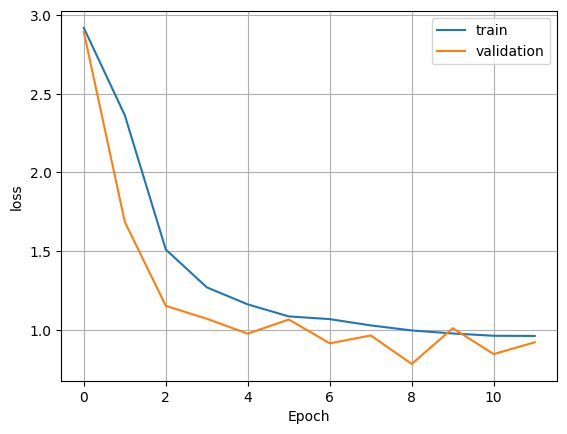

In [ ]:
plot_loss(history4)

In [ ]:
result4 = model4.evaluate(test_data_set)
result4

787/787 ━━━━━━━━━━━━━━━━━━━━ 30s 38ms/step - accuracy: 0.7663 - loss: 0.7606


[0.769180178642273, 0.7638580203056335]

# Model 5: Transfer Learning

In [ ]:
# Get data - https://www.tensorflow.org/tutorials/load_data/images#load_data_using_a_keras_utility

# Parameters
batch_size = 125912
IMG_SIZE = (224, 224)
data_dir = './hagridset'
seed_no = 388741
validation_split = 0.3

# Dataset - https://stackoverflow.com/questions/66036271/splitting-a-tensorflow-dataset-into-training-test-and-validation-sets-from-ker

# Auto split to training set (70%)
training_data_set = tf.keras.utils.image_dataset_from_directory(data_dir,
                                                       image_size = IMG_SIZE,
                                                       validation_split = validation_split,
                                                       subset = 'training',
                                                       seed = seed_no,
                                                       color_mode = "rgb",
                                                       label_mode='categorical',
                                                       shuffle = True)

# Auto split to validation set and test set (30%)
validation_data_set = tf.keras.utils.image_dataset_from_directory(data_dir,
                                                       image_size = IMG_SIZE,
                                                       validation_split = validation_split,
                                                       subset = 'validation',
                                                       seed = seed_no,
                                                       color_mode = "rgb",
                                                       label_mode='categorical',
                                                       shuffle = True)

# Split further to validation set (10%) and test set (20%)
validation_batches = tf.data.experimental.cardinality(validation_data_set)
test_data_set = validation_data_set.take((2 * validation_batches) // 3)
validation_data_set = validation_data_set.skip((2 * validation_batches) // 3)

Found 125912 files belonging to 18 classes.
Using 88139 files for training.
Found 125912 files belonging to 18 classes.
Using 37773 files for validation.


In [ ]:
# Parameters
num_classes = len(training_data_set.class_names)

# Building the Model
model5_base = tf.keras.applications.VGG16(
    weights='imagenet',
    input_shape=(IMG_SIZE[0], IMG_SIZE[1],3),
    include_top=False)
model5_base.trainable = False

inputs = tf.keras.Input(shape=(IMG_SIZE[0], IMG_SIZE[1],3))
x = model5_base(inputs, training=False)
x = tf.keras.layers.GlobalAveragePooling2D()(x)
outputs = tf.keras.layers.Dense(num_classes, activation='softmax')(x)

model5 = tf.keras.Model(inputs, outputs)

# Compile the Model
model5.compile(optimizer=tf.keras.optimizers.Adam(),
              loss=tf.keras.losses.CategoricalCrossentropy(from_logits=False),
              metrics=['accuracy'])

In [ ]:
model5.summary()

Model: "functional_46"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_4 (InputLayer)      │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ vgg16 (Functional)              │ (None, 7, 7, 512)      │    14,714,688 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 512)            │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 18)             │         9,234 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 14,723,922 (56.17 MB)

 Trainable params: 9,234 (36.07 KB)

 Non-trainable params: 14,714,688 (56.13 MB)

In [ ]:
callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)
history5 = model5.fit(training_data_set, validation_data=validation_data_set, epochs=50, callbacks=[callback])

Epoch 1/50


I0000 00:00:1715883108.182669   34300 asm_compiler.cc:369] ptxas warning : Registers are spilled to local memory in function 'triton_gemm_dot_753', 20 bytes spill stores, 20 bytes spill loads

2024-05-16 19:12:01.955395: E external/local_xla/xla/service/slow_operation_alarm.cc:65] Trying algorithm eng11{k2=2,k3=0} for conv (f32[32,128,112,112]{3,2,1,0}, u8[0]{0}) custom-call(f32[32,128,112,112]{3,2,1,0}, f32[128,128,3,3]{3,2,1,0}, f32[128]{0}), window={size=3x3 pad=1_1x1_1}, dim_labels=bf01_oi01->bf01, custom_call_target="__cudnn$convBiasActivationForward", backend_config={"operation_queue_id":"0","wait_on_operation_queues":[],"cudnn_conv_backend_config":{"conv_result_scale":1,"activation_mode":"kRelu","side_input_scale":0,"leakyrelu_alpha":0}} is taking a while...
2024-05-16 19:12:02.515308: E external/local_xla/xla/service/slow_operation_alarm.cc:133] The operation took 1.551393878s
Trying algorithm eng11{k2=2,k3=0} for conv (f32[32,128,112,112]{3,2,1,0}, u8[0]{0}) custom-call(f32[32

2754/2755 ━━━━━━━━━━━━━━━━━━━━ 0s 177ms/step - accuracy: 0.4112 - loss: 2.7122

I0000 00:00:1715883623.610772   37894 asm_compiler.cc:369] ptxas warning : Registers are spilled to local memory in function 'triton_gemm_dot_753', 4 bytes spill stores, 4 bytes spill loads



2755/2755 ━━━━━━━━━━━━━━━━━━━━ 0s 182ms/step - accuracy: 0.4112 - loss: 2.7118

I0000 00:00:1715883722.798729   38658 asm_compiler.cc:369] ptxas warning : Registers are spilled to local memory in function 'triton_gemm_dot_210', 4 bytes spill stores, 4 bytes spill loads



2755/2755 ━━━━━━━━━━━━━━━━━━━━ 630s 219ms/step - accuracy: 0.4113 - loss: 2.7115 - val_accuracy: 0.6103 - val_loss: 1.3308
Epoch 2/50
2755/2755 ━━━━━━━━━━━━━━━━━━━━ 580s 210ms/step - accuracy: 0.6377 - loss: 1.1945 - val_accuracy: 0.6345 - val_loss: 1.2261
Epoch 3/50
2755/2755 ━━━━━━━━━━━━━━━━━━━━ 13936s 5s/step - accuracy: 0.6501 - loss: 1.1527 - val_accuracy: 0.6380 - val_loss: 1.2075
Epoch 4/50
2755/2755 ━━━━━━━━━━━━━━━━━━━━ 521s 189ms/step - accuracy: 0.6532 - loss: 1.1473 - val_accuracy: 0.6457 - val_loss: 1.2029
Epoch 5/50
2755/2755 ━━━━━━━━━━━━━━━━━━━━ 519s 188ms/step - accuracy: 0.6545 - loss: 1.1525 - val_accuracy: 0.6387 - val_loss: 1.2388
Epoch 6/50
2755/2755 ━━━━━━━━━━━━━━━━━━━━ 505s 183ms/step - accuracy: 0.6547 - loss: 1.1465 - val_accuracy: 0.6398 - val_loss: 1.2347
Epoch 7/50
2755/2755 ━━━━━━━━━━━━━━━━━━━━ 539s 196ms/step - accuracy: 0.6560 - loss: 1.1487 - val_accuracy: 0.6441 - val_loss: 1.2128


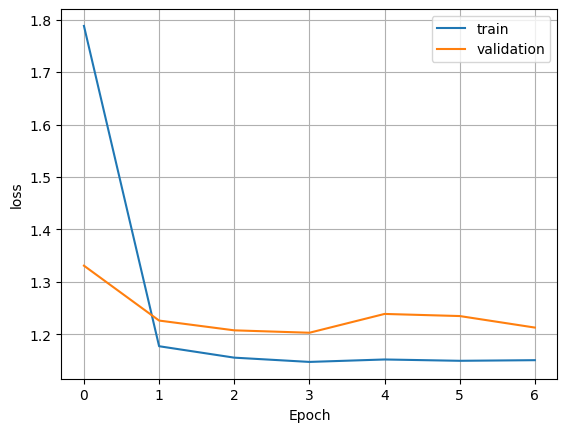

In [ ]:
plot_loss(history5)

In [ ]:
result5 = model5.evaluate(test_data_set)
result5

787/787 ━━━━━━━━━━━━━━━━━━━━ 143s 181ms/step - accuracy: 0.6461 - loss: 1.1851


[1.1930475234985352, 0.6498570442199707]

# Choosing the best model

In [ ]:
print("Model 1 (Manual Greyscale - Simple): "+str(result1[1]))
print("Model 2 (Manual Greyscale - Deep): "+str(result2[1]))
print("Model 3 (Manual RGB - Deep): "+str(result3[1]))
print("Model 3 (Manual RGB - Deep with Dropout): "+str(result4[1]))
print("Model 5 (Transfer Learning): "+str(result5[1]))

model_list = [model, model2, model3, model4, model5]
results_acc_list = [result1[1], result2[1], result3[1], result4[1], result5[1]]

Model 1 (Manual Greyscale - Simple): 0.15938691794872284
Model 2 (Manual Greyscale - Deep): 0.802811324596405
Model 3 (Manual RGB - Deep): 0.8395807147026062
Model 3 (Manual RGB - Deep with Dropout): 0.7638580203056335
Model 5 (Transfer Learning): 0.6498570442199707


In [ ]:
# Get best accuracy
best_accuracy = max(results_acc_list)
best_accuracy_index = results_acc_list.index(best_accuracy)
print("Best Accuracy: "+str(best_accuracy))
print("Model Number: "+str(best_accuracy_index+1))

best_model = model_list[best_accuracy_index]

Best Accuracy: 0.8395807147026062
Model Number: 3


# Test with own images

In [ ]:
# Parameters
batch_size = 125912
IMG_SIZE = (512, 512)
data_dir = './testing_own'
seed_no = 388741
validation_split = 0.3

# Dataset - https://stackoverflow.com/questions/66036271/splitting-a-tensorflow-dataset-into-training-test-and-validation-sets-from-ker

# Own testing data set
own_testing_data_set = tf.keras.utils.image_dataset_from_directory(data_dir,
                                                       image_size = IMG_SIZE,
                                                       shuffle = False)

Found 4 files belonging to 4 classes.


In [ ]:
class_names = training_data_set.class_names

probability_model = tf.keras.Sequential([best_model, tf.keras.layers.Softmax()])

predictions = probability_model.predict(own_testing_data_set)
df = pd.DataFrame(predictions, columns=class_names, index=own_testing_data_set.file_paths)
df

1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step


,call,dislike,fist,four,like,mute,ok,one,palm,peace,peace_inverted,rock,stop,stop_inverted,three,three2,two_up,two_up_inverted
./testing_own/ok/okay.jpg,0.050720,0.050720,0.050720,0.050720,0.050720,0.050720,0.137688,0.050720,0.050720,0.050723,0.050782,0.050721,0.050720,0.050720,0.050722,0.050721,0.050720,0.050720
./testing_own/one/one.jpg,0.050728,0.050728,0.050729,0.050728,0.050788,0.050728,0.050728,0.137464,0.050728,0.050730,0.050728,0.050754,0.050728,0.050728,0.050728,0.050728,0.050797,0.050729
./testing_own/peace/peace.jpg,0.050802,0.050802,0.050802,0.050802,0.050802,0.050802,0.050802,0.050814,0.050802,0.135328,0.050809,0.050807,0.050802,0.050802,0.050802,0.051802,0.050816,0.050802
./testing_own/stop/stop.jpg,0.050796,0.050796,0.050800,0.050840,0.050796,0.050796,0.050813,0.050796,0.051286,0.050796,0.050796,0.050796,0.135504,0.051199,0.050799,0.050796,0.050796,0.050796


In [ ]:
df['Max'] = df.idxmax(axis=1)
df['Max']

./testing_own/ok/okay.jpg           ok
./testing_own/one/one.jpg          one
./testing_own/peace/peace.jpg    peace
./testing_own/stop/stop.jpg       stop
Name: Max, dtype: object